# Laboratoire 4 - Modèle de déplacement

> **Attention!** Il est *strictement interdit* de s'approcher des commandes qui font avancer le robot si il y a le moindre risque que le robot ne tombe par terre. Les équipes qui ont un accidents de robot devront chanter *Never Gonna Give You Up* devant toute la classe.

L'objectif de ce laboratoire est de créer un modèle de déplacement pour la plate-forme Kobuki. Pour ce faire nous allons observer à plusieurs reprises le comportement réel du robot. Nous allons comparer ce comportement aux commandes qu'on lui a donné, et créer un modèle gaussien de déplacement.

## Partie 1 - Contrôle du robot

La librarie `robmob` contient une série de commandes de déplacement. Testez les ici avant de continuer! Mais d'abord, importons quelques libraries.

In [1]:
import robmob.robot
import robmob.sensors as sensors
from math import pi as PI

robot_ip = '192.168.0.105'
robot = robmob.robot.Robot(robot_ip)

robot.connect()

In [ ]:
robot.rotate(2*PI / 10, time_of_angular_movement(2*PI/10, PI)) # Rotation de 360 degrés à 60 degrés/seconde

In [ ]:
robot.rotate(-360, -60.0) # Rotation dans le sens contraire

In [ ]:
robot.general_movement_command(0.2, 0, 10)

In [2]:
MAX_LINEAR_ACCELERATION = 0.5
MIN_LINEAR_ACCELERATION = -0.5 * 1.2

MAX_ANGULAR_ACCELERATION = 3.5
MIN_ANGULAR_ACCELERATION = -3.5 * 1.2

def time_of_linear_movement(speed, distance):
    total_time = 0.
    
    time_to_top_speed = speed / MAX_LINEAR_ACCELERATION
    distance -= time_to_top_speed * speed / 2.
    total_time += time_to_top_speed
    
    time_to_stop = -speed / MIN_LINEAR_ACCELERATION
    distance -= time_to_stop * speed / 2.
    total_time += time_to_stop
    
    total_time += distance / speed
    
    return total_time

def time_of_angular_movement(speed, angle):
    total_time = 0.
    
    time_to_top_speed = speed / MAX_ANGULAR_ACCELERATION
    angle -= time_to_top_speed * speed / 2.
    total_time += time_to_top_speed
    
    time_to_stop = -speed / MIN_ANGULAR_ACCELERATION
    angle -= time_to_stop * speed / 2.
    total_time += time_to_stop
    
    total_time += angle / speed
    
    return total_time
    

In [ ]:
time_of_linear_movement(0.2, 1)
time_of_angular_movement(3.1416/5, 3.1416)

In [ ]:
5/5.3

## Grapher les ticks de l'odomètre

In [3]:
odometer = sensors.OdometerTicksSensor(30 * sensors.OdometerTicksSensor.SAMPLE_RATE) # 10 sec buffer size.
robot.add_sensor(odometer)

In [4]:
import numpy as np

def get_odometry_data():
    odometry_data = []
    buf_snapshot = odometer.read_buffer()
    for data in buf_snapshot:
        row = [
                data[0]['secs'] * 1e9 + data[0]['nsecs'],
                data[1],
                data[2]
            ]
        odometry_data.append(row)

    odometry_data = np.array(odometry_data)
    odometry_data[:,0] -= odometry_data[0,0]
    return odometry_data

def average_tps_of_odom_data(odom_data):
    time_of_min = 0.0
    
    i = 0
    while odom_data[i,1] == odom_data[0,1]:
        i += 1
    
    time_of_min = odom_data[i,0]
    value_of_min = odom_data[i,1]
    
    while odom_data[i,1] < odom_data[i + 1, 1]:
        i += 1
    
    time_of_max = odom_data[i+1, 0]
    value_of_max = odom_data[i+1, 1]
    
    print('max {}, min {}'.format(value_of_max, value_of_min))
    
    return (value_of_max - value_of_min) / (time_of_max - time_of_min) * 1e9

In [14]:
import time

robot.move(0.2, time_of_linear_movement(0.2, 2))
time.sleep(2)
odometry_data = get_odometry_data()

odometry_data

array([[  0.00000000e+00,   1.96020000e+04,   2.76370000e+04],
       [  1.99930880e+07,   1.96020000e+04,   2.76370000e+04],
       [  3.93392640e+07,   1.96020000e+04,   2.76370000e+04],
       ..., 
       [  2.99132570e+10,   4.10050000e+04,   4.89270000e+04],
       [  2.99329162e+10,   4.10050000e+04,   4.89270000e+04],
       [  2.99530724e+10,   4.10050000e+04,   4.89270000e+04]])

In [15]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import time

<IPython.core.display.Javascript object>


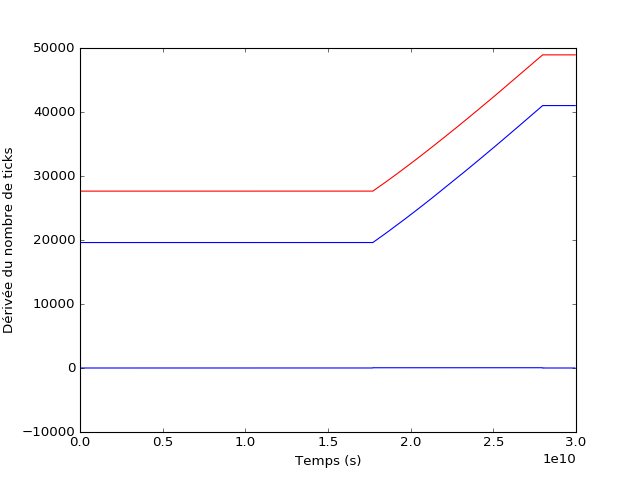

In [16]:


plt.plot(odometry_data[:, 0], odometry_data[:, 1], 'b')
plt.plot(odometry_data[:, 0], odometry_data[:, 2], 'r')
plt.show()

<IPython.core.display.Javascript object>


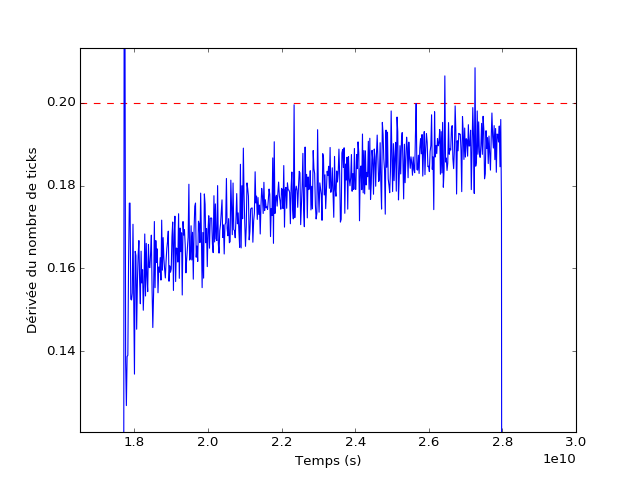

In [28]:
deltas = []

for i in range(odometry_data.shape[0] - 1):
    n_ticks = odometry_data[i + 1,1] - odometry_data[i,1]
    delta_t = (odometry_data[i+1, 0] - odometry_data[i,0]) / 1e9
    
    delta_x = n_ticks / 11724.41658029856624751591
    
    
    deltas.append([odometry_data[i,0], delta_x / delta_t])
    
deltas = np.array(deltas)

plt.axhline(0.2, linestyle='--', color='r')
plt.plot(deltas[:,0], deltas[:,1])
plt.xlabel('Temps (s)')
plt.ylabel('Dérivée du nombre de ticks')


In [ ]:
import time

robot.move(0.2, time_of_linear_movement(0.2, 2))
time.sleep(2)
odometry_data = get_odometry_data()

In [ ]:
average_tps_of_odom_data(odometry_data)

In [ ]:
calibration_data = []

for distance in [0.2, 0.4, 0.6, 0.8, 1.0]:
    robot.move(0.2, time_of_linear_movement(0.2, distance))
    time.sleep(2)
    odometry_data = get_odometry_data()
    calibration_data.append([distance, average_tps_of_odom_data(odometry_data)])
    
calibration_data = np.array(calibration_data)

In [ ]:
odometry_data

In [ ]:
average_tps_of_odom_data(odometry_data)

In [ ]:
calibration_data

In [ ]:
plt.plot(calibration_data[:,0], calibration_data[:, 1])
plt.show()

In [ ]:
m = (calibration_data[4, 1] - calibration_data[1,1]) / (calibration_data[4,0] - calibration_data[1,0])

In [ ]:
m

In [ ]:
calibration_data[4,1]

In [ ]:
b = calibration_data[4,1] - m*calibration_data[4,0]

In [ ]:
b

In [ ]:
m = m / 11724

In [ ]:
b = b / 11724

In [ ]:
m

In [ ]:
b

In [ ]:
m + b

In [ ]:
0.2 / (m + b)

In [ ]:
0.2 * 1.18